<a href="https://colab.research.google.com/github/josejailson/california/blob/main/california_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting the data

In [6]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
  tarball_path = Path("datasets/housing.tgz")
  if not tarball_path.is_file():
    Path("datasets").mkdir(parents=True, exist_ok=True)
    url = "https://github.com/ageron/data/raw/main/housing.tgz"
    urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
      housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

In [10]:
housing = load_housing_data()

In [11]:
housing = pd.read_csv("datasets/housing/housing.csv")

# Creating a train and a test set

In [12]:
import numpy as np


housing['income_cat'] = pd.cut(housing["median_income"],
                              bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                              labels=[1,2,3,4,5])

<Axes: >

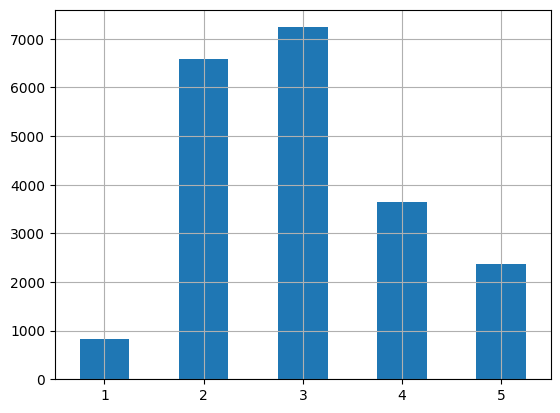

In [13]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)

In [14]:
from sklearn.model_selection import train_test_split

strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

In [15]:
for set_ in (strat_train_set, strat_test_set):
  set_.drop("income_cat", axis=1, inplace=True)

In [16]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_target = strat_train_set["median_house_value"].copy()

# Exploring and visualizing the data to gain insight

In [ ]:
housing = strat_train_set.copy()

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
              s=housing["population"]/100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10,7))

In [ ]:
corr_matrix = housing.corr()

In [ ]:
corr_matrix["median_house_value"].sort_values(ascending=False)

In [ ]:
from pandas.plotting import scatter_matrix
from matplotlib import pyplot as plt


attributes = ['median_house_value', "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))
plt.show()

In [ ]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, grid=True)

In [ ]:
housing['housing_median_age'].value_counts()

In [ ]:
housing.hist(bins=50, figsize=(14,10))

# Data preparation

## Creating new features

In [17]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel


def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

## Columns transformation: handling categorical and numerical data

In [18]:
cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder(handle_unknown="ignore"))
num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

## Handling long tails with log transfomation

In [19]:
log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())


## Custom transformers


In [20]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
  def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
    self.n_clusters = n_clusters
    self.gamma = gamma
    self.random_state = random_state

  def fit(self, X, y=None, sample_weight=None):
    self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
    self.kmeans_.fit(X, sample_weight=sample_weight)
    return self

  def transform(self, X):
    return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma = self.gamma)

  def get_feature_names_out(self, names=None):
    return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)

## Tranformation pipelines

In [21]:
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector


preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=num_pipeline)  # one column remaining: housing_median_age

# Training the model

In [22]:
from sklearn.ensemble import RandomForestRegressor

model = make_pipeline(preprocessing, RandomForestRegressor())

model.fit(housing, housing_target)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x7fa...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa030047820>)])),
                ('randomforestregressor', RandomForestRegressor())])

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val_score(model, housing, housing_target, cv=10)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

# Fine-tuning the model

# Preparing the model for production